- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

#### В качетве данных для задания также был взят уже имеющийся датасет по возрасту (https://archive.ics.uci.edu/ml/datasets/Adult)
Датасет представили:

Ronny Kohavi and Barry Becker
Data Mining and Visualization
Silicon Graphics. 

### 1. Cделать обзорный анализ выбранного датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
colls=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
           'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', sep=',', index_col=False, names = colls)
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [3]:
# заменим значения целевой переменной на бинарные
df['income'] = df['income'].map({' <=50K':0,' >50K':1})

In [4]:
df['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.7+ MB


In [6]:
num_features = df.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()

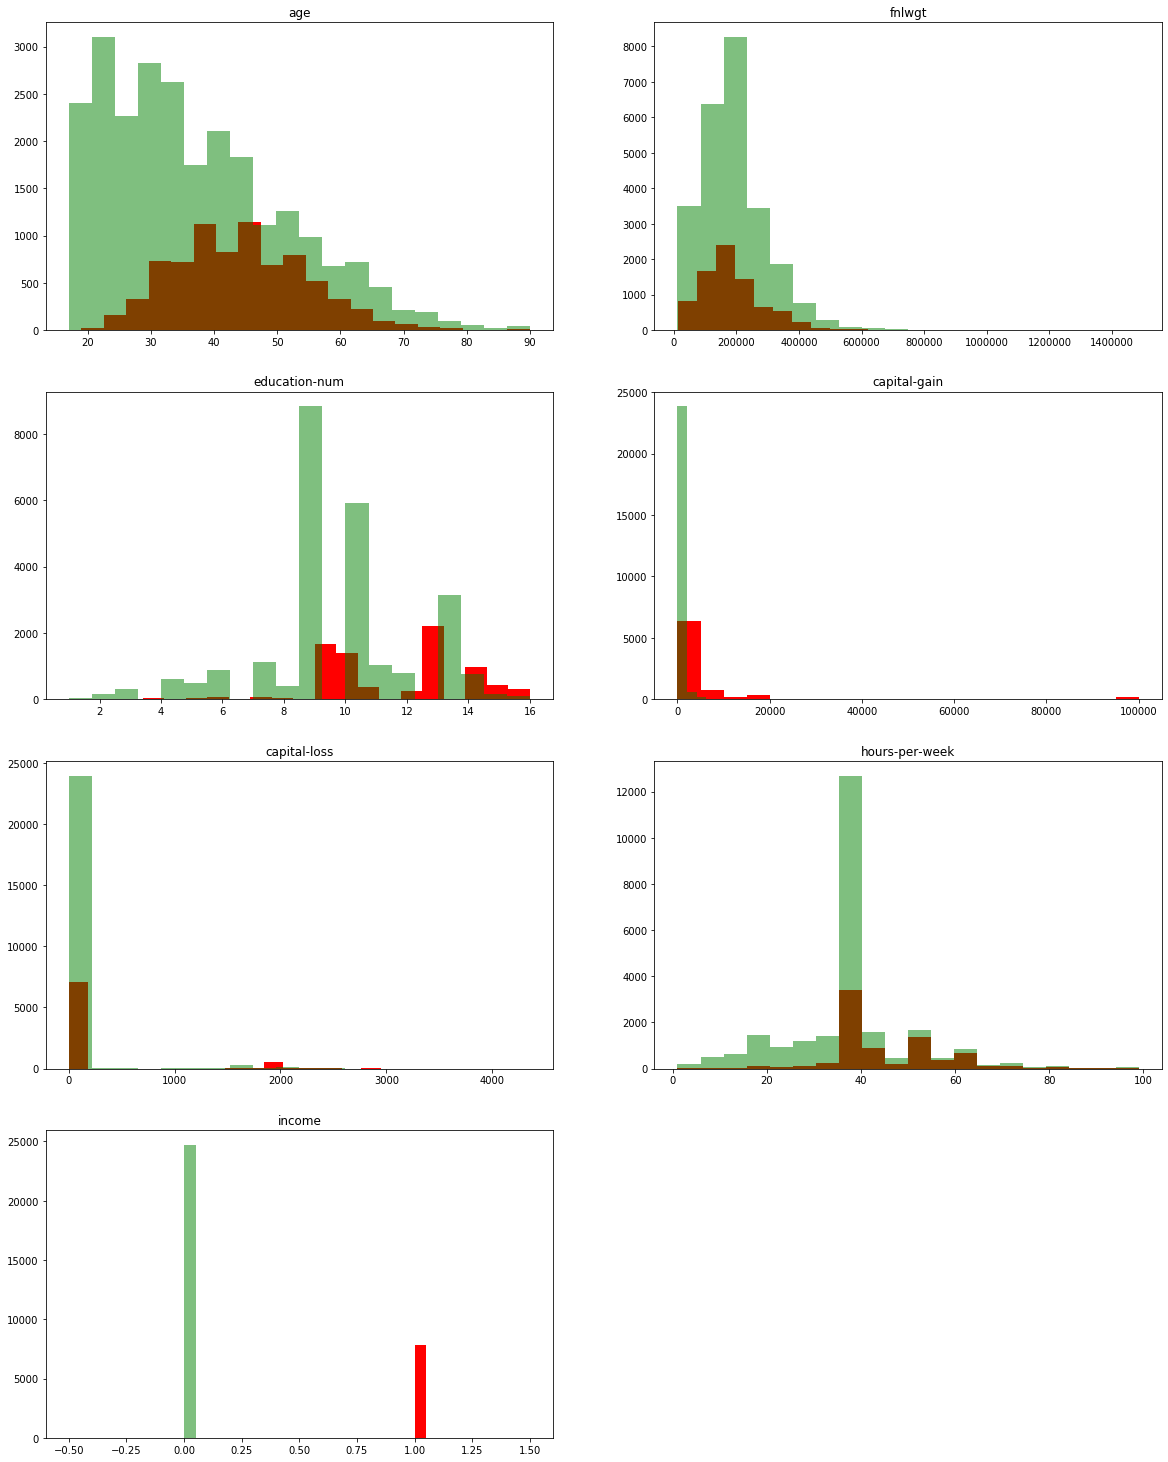

In [7]:
plt.figure(figsize=(20,60))

for i, colname in enumerate(num_features):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    plt.hist(df.loc[df['income'] == 1, colname], alpha = 1, color='r', bins=20)
    plt.hist(df.loc[df['income'] == 0, colname], alpha = 0.5,  color='g', bins=20)
    
plt.show()

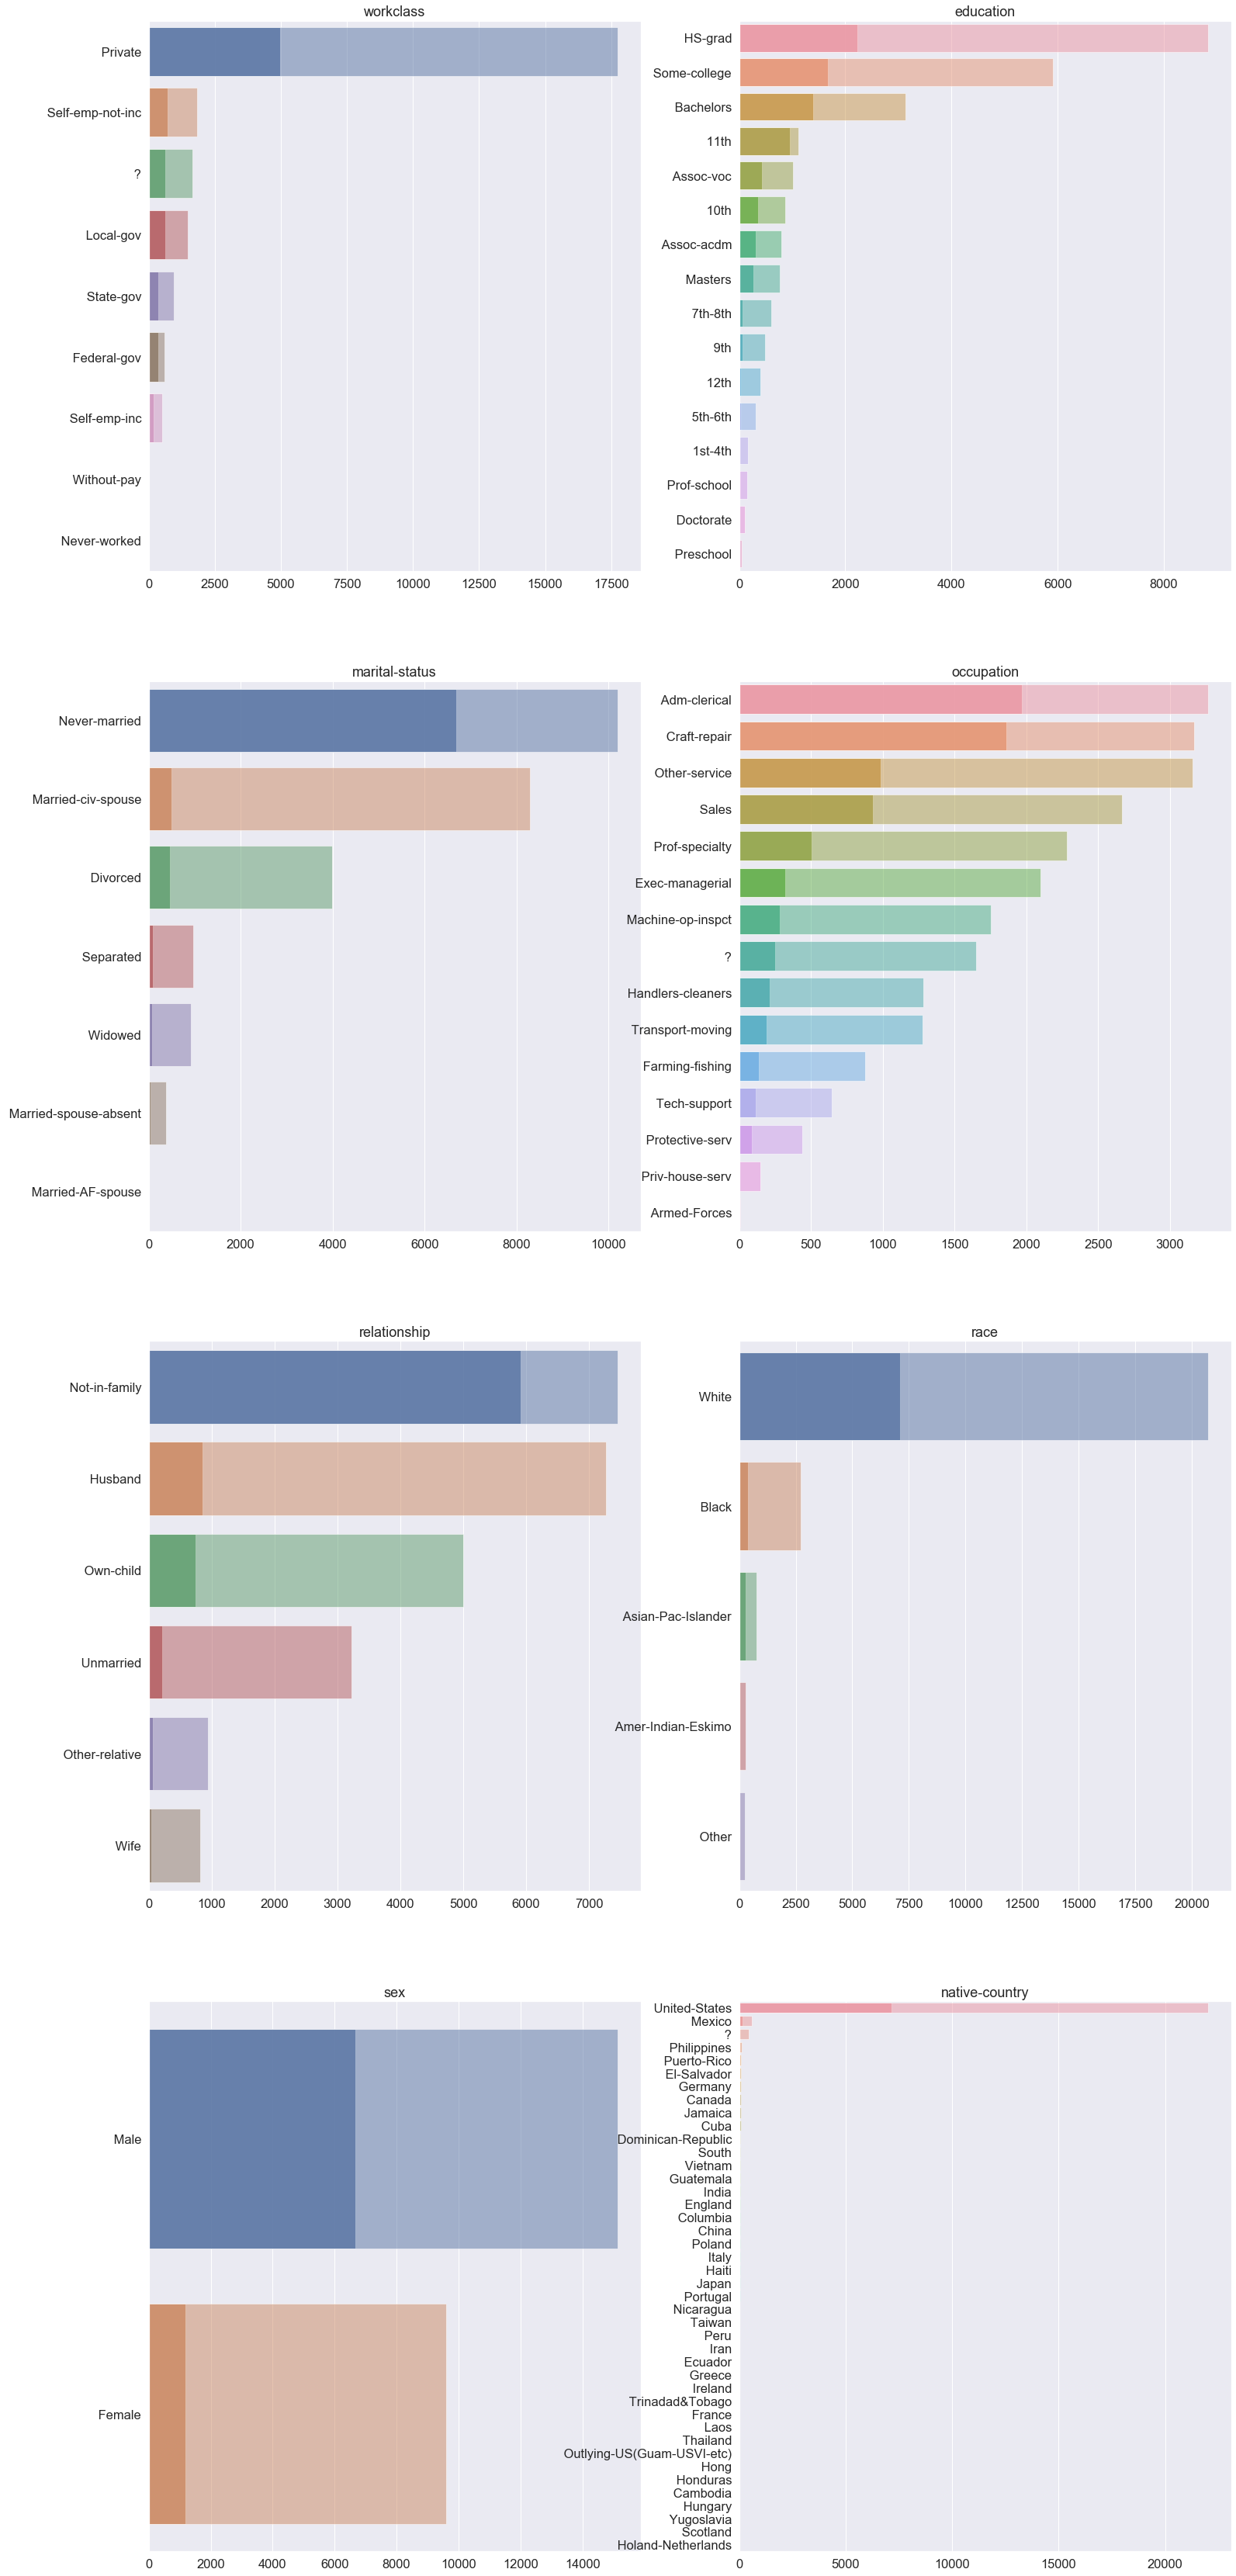

In [8]:
sns.set(font_scale=1.5)
plt.figure(figsize=(25,60))

for i, colname in enumerate(cat_features):
    plt.subplot(4,2,i+1)
    plt.title(colname)
    
    val_counts_t1 = df.loc[df['income'] == 1, colname].value_counts()
    val_counts_t0 = df.loc[df['income'] == 0, colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index,  alpha=0.8)
    sns.barplot(val_counts_t0.values, val_counts_t0.index,  alpha=0.5)
plt.show()

И рассмотрим некоторые перменные в зависимости от образования

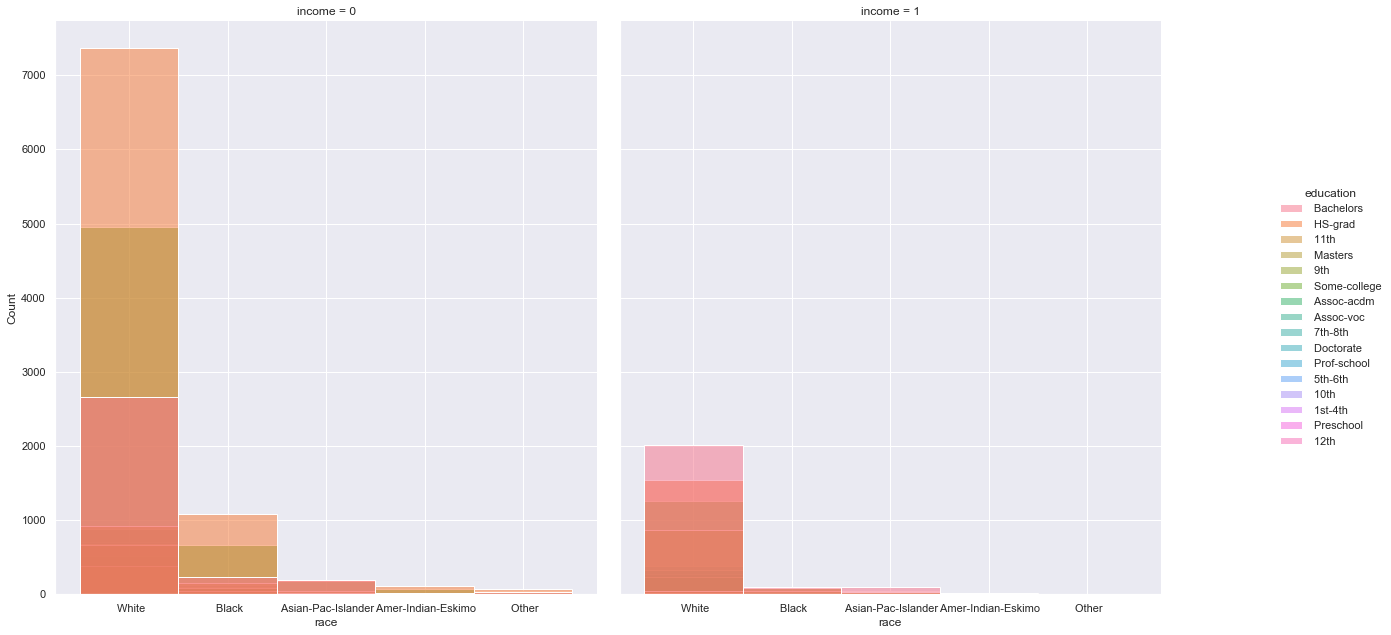

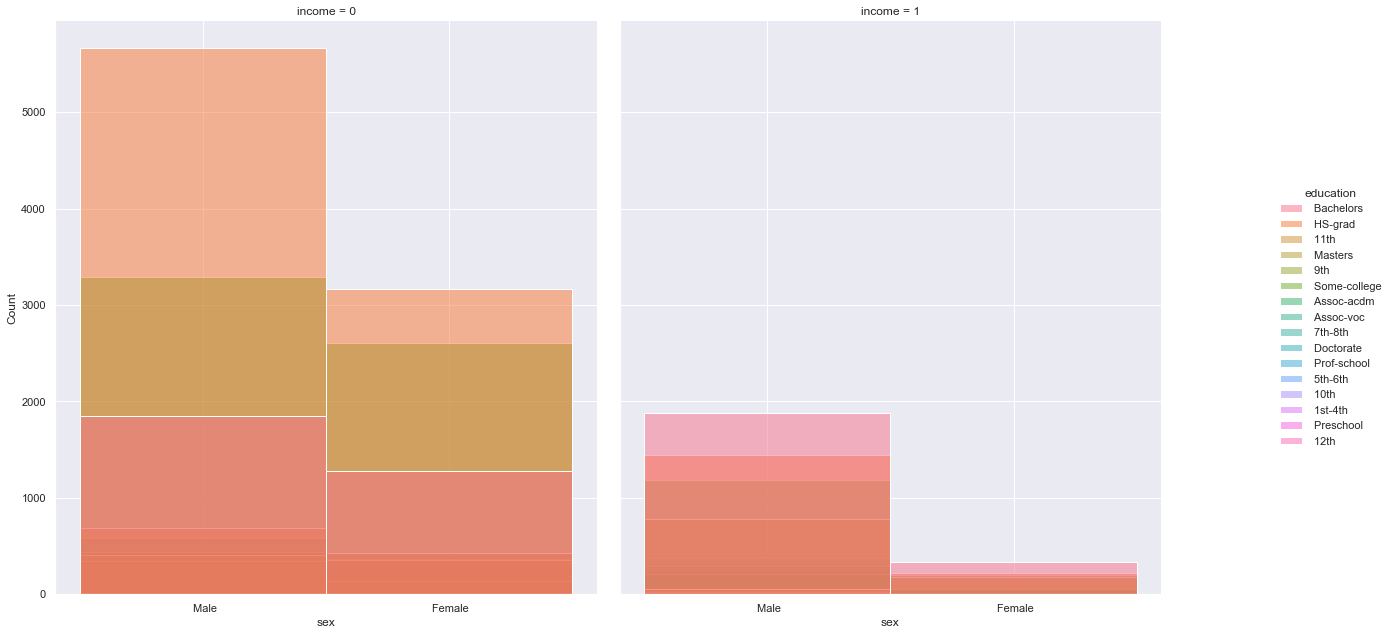

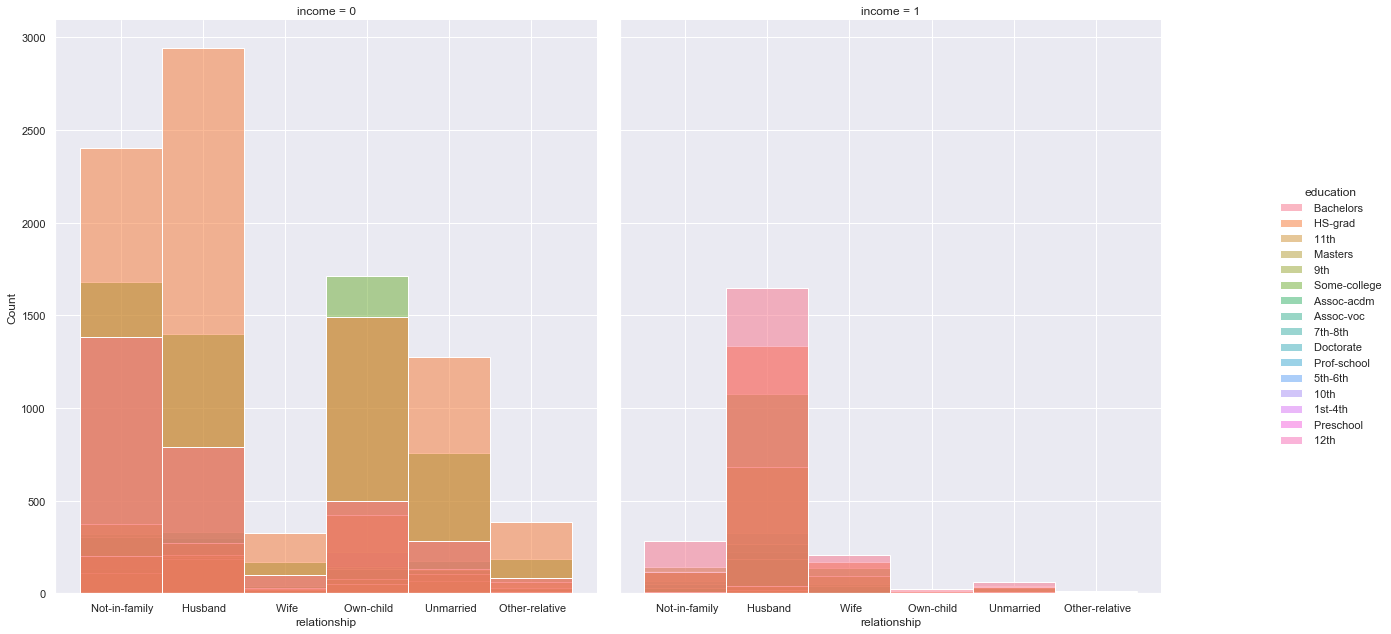

In [9]:
sns.set(font_scale=1)
for col in ['race','sex','relationship']:
    g = sns.displot(data=df, x=col, hue='education', col='income', kind='hist')
    g.fig.set_size_inches(20, 10)

### 2. Future engineering

In [10]:
# Я уже представил целевую переменную в бинарном виде. Сделаем даммис переменные
X = pd.get_dummies(df.drop(columns=['income','fnlwgt'],axis=1))
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

### 3. Для простоты обучим логистическую регрессию

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [12]:
def evaluate_results(y_test, y_predict):
    """ Проверка качества модели с помощью DS-метрик"""
    from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

    return pd.DataFrame(
        [{
            'f1': f1_score(y_test, y_predict),
            'precision': precision_score(y_test, y_predict, average='binary'),
            'recall': recall_score(y_test, y_predict, average='binary'),
            'roc': roc_auc_score(y_test, y_predict),
        }],
        index={'metrics'}).round(3)


evaluate_results(y_test, y_predict)

,f1,precision,recall,roc
metrics,0.613,0.678,0.559,0.737


### 4. SHAP

In [13]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [14]:
%%time
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_train)

Wall time: 125 ms


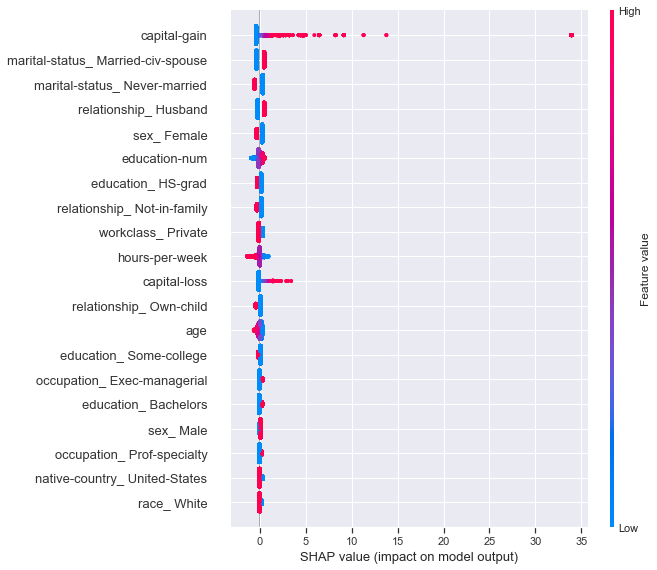

In [15]:
shap.summary_plot(shap_values, X_train)

Мы видим, что наши дамми переменные практически не оказывают влияния на решения модели.

По остальным признакам можно сказать:

1. **Чем больше прирост накоплений, тем больше вероятность закончить год с >50К. Логично**

2. **Можно выделить образование, всеже люди, уделяющие образованию больше времени имеют большие шансы**

3. **Ну и вот что, на первый взгляд, нелогично, так это уменьшение накоплений увеличивает вероятность закончить год с >50К. Можно конечно додумать что уменьшение капитала > инвестиции > дивиденды, но мне кажется что это ошибка моделирования**

4. **С увеличением возраста,хоть и незначительно, но вероятность уменьшается**

5. **И т.д.**



**Если топ10 имеется ввиду признаков, то**

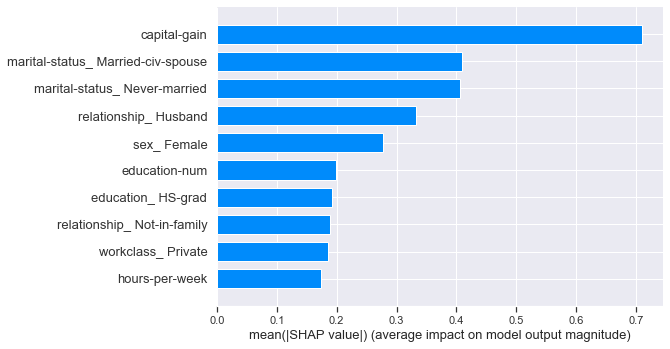

In [18]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

### 5. ForsePlot

In [19]:
ind = 41
shap.force_plot(explainer.expected_value, shap_values[ind,:], X_train.iloc[ind,:])

- Объекту 41 для успеха наиболее важны показатели увеличения накоплений, часы работы в неделю, холостяцкая жизнь)) и т.д.